## Multinomial Naive Bayes Classifier

### The general term Naive Bayes refers the strong independence assumptions in the model. A Naive Bayes model assumes that each of the features it uses are conditionally independent of one another given some class. The term Multinomial Naive Bayes simply lets us know that each $p(f\space |\space c)$ is a multinomial distribution, rather than some other distribution. This works well for data which can easily be turned into counts, such as word counts in text.

                                           
### Environment Setup

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
%matplotlib inline 
import matplotlib.pyplot as plt

### Syntatic NLP Processing

#### We will define some Python functions that will perform some syntatic work on our corpus. 

In [2]:
def tokenize(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [ token for token in tokens if re.search('(^[a-zA-Z]+$)', token) ]
    return filtered_tokens

cachedStopWords = stopwords.words("english")
noisywords = ['year', 'old', 'man', 'woman', 'ap', 'am', 'pm', 'portable', 'pa', 'lat', 'admitting', 'diagnosis', 'lateral']
cachedStopWords.extend(noisywords)
print(cachedStopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Retrieving our Corpus

#### Let's pull in our corpus that we had serialized out to disk.  

In [3]:
file = open('differential-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()
corpusList = list(corpus['text'].tolist())
labels = list(corpus['label'].tolist())
corpus.head()

,text,label
0,[**2996-12-2**] 10:25 AM\n CT CHEST W/O CONTRA...,PNA
1,[**3201-9-21**] 4:50 PM\n CT CHEST W/CONTRAST ...,PNA
2,[**3299-6-23**] 5:06 PM\n CT CHEST W/CONTRAST ...,PNA
3,[**3186-6-14**] 2:54 PM\n CT CHEST W/CONTRAST ...,PNA
4,[**2500-1-17**] 9:41 PM\n CT CHEST W/O CONTRAS...,PNA


### Generate Document-Term Frequency Counts

#### In this step we tokenize our text and remove stop words in addition to generating our frequency counts.

#### 1) How many documents are we working with and how many features (unigrams & bigrams)?

#### 2) Can you figure out what max_df and min_df is doing to our feature count?

In [4]:
#cv = CountVectorizer(lowercase=True, max_df=0.90, max_features=None, min_df=0.033,
#                     ngram_range=(1, 2), preprocessor=None, stop_words=cachedStopWords,
#                     strip_accents=None, tokenizer=tokenize, vocabulary=None)
cv = TfidfVectorizer(lowercase=True, max_df=0.90, max_features=None, min_df=0.033,
                     ngram_range=(1, 2), preprocessor=None, stop_words=cachedStopWords,
                     strip_accents=None, tokenizer=tokenize, vocabulary=None)
X = cv.fit_transform(corpusList)
print(X.shape)
print()
lexicon = cv.get_feature_names()
print (lexicon)
print()

D:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(1500, 920)

['abdomen', 'abdomen pelvis', 'abdominal', 'abnormalities', 'abnormality', 'acquired', 'acute', 'addition', 'additional', 'additionally', 'adenopathy', 'adjacent', 'administered', 'administration', 'administration cc', 'administration iv', 'admitted', 'adrenal', 'adrenal glands', 'air', 'air bronchograms', 'airspace', 'airways', 'airways patent', 'allowing', 'along', 'also', 'also noted', 'although', 'alveolar', 'amount', 'amt', 'amt final', 'amt underlying', 'angle', 'anterior', 'aorta', 'aortic', 'apex', 'apical', 'apices', 'appear', 'appearance', 'appears', 'appropriate', 'approximately', 'approximately cm', 'arch', 'area', 'areas', 'areas consolidation', 'arterial', 'arteries', 'artery', 'artery calcifications', 'ascites', 'aspect', 'aspiration', 'assess', 'assessment', 'associated', 'asthma', 'atelectasis', 'atelectasis left', 'atelectasis right', 'atherosclerotic', 'atrial', 'atrium', 'attenuation', 'available', 'axial', 'axial images', 'axillary', 'axillary lymphade

### Construct our Classes

#### We need to assign a class for each classification. We typically assign numeric values to classes.

In [5]:
corpus['label'] = corpus['label'].map({'COPD': 0, 'CHF': 0, 'PNA': 1})
corpus.head()
Y = corpus['label'].values

### Let's Run It!

#### We will generate models and evaluate the modes using 10-fold cross-validation.

In [6]:
results = []
cont = []
kf = KFold(n_splits=10, shuffle=True)
alpha = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
for a in range(len(alpha)):
    fold = 1
    truth = []
    mnb_prediction = []
    print("model ", a, ": Naive Bayes alpha = " + str(alpha[a]))
    test_count = 0
    mnb = MultinomialNB(alpha=alpha[a], class_prior=None, fit_prior=True)
    for train_idx, test_idx in kf.split(X):
        trainX = X[train_idx]
        trainY = Y[train_idx]
        testX = X[test_idx]
        testY = Y[test_idx]
        truth.append(testY)
        mnb.fit(trainX, trainY)
        Y_hat = mnb.predict(testX)
        mnb_prediction.append(Y_hat)
        print("   Fold %d accuracy: %.2f %%" % (fold, ((np.sum(Y_hat == testY)/len(testY)) * 100.0)))                        
        fold += 1
    truth = np.concatenate(truth, axis=0)    
    mnb_prediction = np.concatenate(mnb_prediction, axis=0)
    test_results = np.sum(mnb_prediction == truth)/len(truth)
    print("     Overall test accuracy: %.2f %%" % (test_results * 100))  
    mnb = mnb.fit(X, Y)
    Y_hat = mnb.predict(X)
    train_results = np.sum(Y_hat == Y)/len(Y)
    print("     Overall training accuracy: %.2f %%" % (train_results * 100.0))  
    results.append([train_results, test_results])   
    cont.append([truth, mnb_prediction])

model  0 : Naive Bayes alpha = 0.5
   Fold 1 accuracy: 73.33 %
   Fold 2 accuracy: 78.00 %
   Fold 3 accuracy: 87.33 %
   Fold 4 accuracy: 76.67 %
   Fold 5 accuracy: 83.33 %
   Fold 6 accuracy: 79.33 %
   Fold 7 accuracy: 78.00 %
   Fold 8 accuracy: 80.00 %
   Fold 9 accuracy: 82.00 %
   Fold 10 accuracy: 75.33 %
     Overall test accuracy: 79.33 %
     Overall training accuracy: 79.93 %
model  1 : Naive Bayes alpha = 1.0
   Fold 1 accuracy: 77.33 %
   Fold 2 accuracy: 83.33 %
   Fold 3 accuracy: 81.33 %
   Fold 4 accuracy: 82.00 %
   Fold 5 accuracy: 78.00 %
   Fold 6 accuracy: 78.67 %
   Fold 7 accuracy: 81.33 %
   Fold 8 accuracy: 76.67 %
   Fold 9 accuracy: 80.67 %
   Fold 10 accuracy: 75.33 %
     Overall test accuracy: 79.47 %
     Overall training accuracy: 79.73 %
model  2 : Naive Bayes alpha = 2.0
   Fold 1 accuracy: 80.67 %
   Fold 2 accuracy: 78.67 %
   Fold 3 accuracy: 86.00 %
   Fold 4 accuracy: 78.67 %
   Fold 5 accuracy: 84.00 %
   Fold 6 accuracy: 77.33 %
   Fold 7 acc

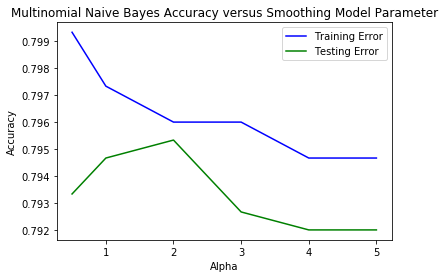

In [7]:
tracc = [item[0] for item in results]
tstacc = [item[1] for item in results]

trainAcc = plt.plot(alpha, tracc, '-b', label='Training Error')
testACC = plt.plot(alpha, tstacc, '-g', label='Testing Error')
plt.title("Multinomial Naive Bayes Accuracy versus Smoothing Model Parameter")
plt.ylabel("Accuracy")
plt.xlabel("Alpha")
plt.legend(loc="best")
plt.show(block=False)

### Contingency Tables

#### Let's look at the contingency tables

#### 1) Can you calculate the Sensitivity, Specificity, PPV, NPV? 

In [8]:
model = input("Enter Best Model: ")
best = cont[int(model)]
mnb_ct = pd.crosstab(best[1], best[0], margins=True)
mnb_ct.columns = ["Other", "PNA", "Total"]
mnb_ct.index = ["Other", "PNA", "Total"]
print()
print("Multinomial Naive Bayes")
print(mnb_ct)
print()


Enter Best Model: 2

Multinomial Naive Bayes
       Other  PNA  Total
Other    861  168   1029
PNA      139  332    471
Total   1000  500   1500



### Evaluation Statistics

#### We will calculate some test statistics for our classifiers

In [9]:
Sens = mnb_ct.iloc[1][1]/mnb_ct.iloc[2][1]
Spec = mnb_ct.iloc[0][0]/mnb_ct.iloc[2][0]
PPV = mnb_ct.iloc[1][1]/mnb_ct.iloc[1][2]
NPV = mnb_ct.iloc[0][0]/mnb_ct.iloc[0][2]
ACC = (mnb_ct.iloc[0][0] + mnb_ct.iloc[1][1]) / mnb_ct.iloc[2][2]
print("Multinomial Naive Bayes: Sensitivity: %.5f Specificity: %.5f PPV: %.5f NPV: %.5f Accuracy: %.5f" % (Sens, Spec, PPV, NPV, ACC))                                                                                      

Multinomial Naive Bayes: Sensitivity: 0.66400 Specificity: 0.86100 PPV: 0.70488 NPV: 0.83673 Accuracy: 0.79533


### ROC Curve

#### 1) So which classifier do you think is better?

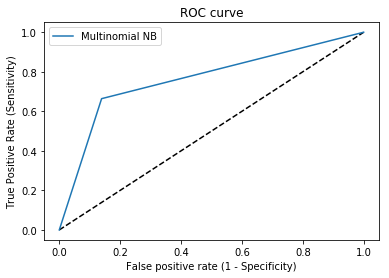

AUC =  0.7625000000000001


In [10]:
mnb_fpr, mnb_tpr, mnb_thresholds = roc_curve(best[0], best[1], pos_label=1)
roc_auc = auc(mnb_fpr, mnb_tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(mnb_fpr, mnb_tpr, label='Multinomial NB')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)